### ReAct Agent Architecture

#### Aim
This is the intuition behind ReAct, a general agent architecture.

1. act - let the model call specific tools
2. observe - pass the tool output back to the model
3. reason - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [2]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [3]:
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [4]:
wiki.invoke("What is AGI?")

'Page: Artificial general intelligence\nSummary: Artificial general intelligence (AGI)—sometimes called human‑level intelligence AI—is a type of artificial intelligence that would match or surpass human capabilities across virtually all cognitive tasks.\nSome researchers argue that state‑of‑the‑art large language models (LLMs) already exhibit signs of AGI‑level capability, while others maintain that genuine AGI has not yet been achieved. Beyond AGI, artificial superintelligence (ASI) would outperfo'

In [5]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"]="ReAct-agent"


In [6]:
### Custom Functions
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools=[arxiv,wiki,add,multiply,divide]

In [7]:
### Tavily Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

C:\Users\rajpu\AppData\Local\Temp\ipykernel_4708\3584238.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [8]:
tavily.invoke("Provide me the recent AI news for march 3rd 2025")

[{'title': 'Top 5 AI trends in March 2025: AI agents, smarter supply chains ...',
  'url': 'https://www.neudesic.com/blog/top-5-ai-trends-march-2025/',
  'content': 'March 2025 has brought a fresh wave of AI innovations that go beyond theoretical breakthroughs and translate directly into real-world impact. From OpenAI’s newly released tools for building AI agents to Microsoft’s external knowledge integration approach, this month’s highlights underscore how artificial intelligence is evolving in ways that matter today, not just tomorrow. Whether it’s optimizing supply chains, pushing the limits of robotics, or making AI systems smarter and more trustworthy, [...] Below, we delve into five top AI trends from March 2025 and explore the practical ways they’re changing industries—from retail to robotics—and setting the stage for what’s ahead. \n\n## 1. OpenAI Releases New Tools for Building AI Agents [...] ## Looking ahead',
  'score': 0.9996724},
 {'title': 'The latest AI news we announced

In [9]:
### Combine all the tools in the list

tools=[arxiv,wiki,tavily,add,divide,multiply]

In [10]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="qwen/qwen3-32b")
response = llm.invoke("Write a code for binary search in c++")

In [11]:
response

AIMessage(content='<think>\nOkay, I need to write a C++ code for binary search. Let me think about how binary search works. Binary search is an efficient algorithm for finding an item in a sorted list. It works by repeatedly dividing the search interval in half. The steps are something like this: compare the target value to the middle element; if they are equal, return the index. If the target is less than the middle element, search the left half. Otherwise, search the right half. Repeat until found or conclude it\'s not present.\n\nFirst, I need to decide whether the array is sorted. Wait, the user probably expects the function to work on a sorted array, so maybe I should mention that the array must be sorted before applying binary search.\n\nNow, the parameters for the function. Let me think: the array, the low and high indices, or maybe just the array, the size, and the target. Alternatively, a function that takes the array, low, high, and target. I\'ll need to write a helper functi

In [12]:
llm_with_tools = llm.bind_tools(tools)

In [13]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002ACA0314440>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002ACA040FAD0>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'arxiv', 'description': 'A wrapper around Arxiv.org Useful for when you need to answer questions about Physics, Mathematics, Computer Science, Quantitative Biology, Quantitative Finance, Statistics, Electrical Engineering, and Economics from scientific articles on arxiv.org. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'wikipedia', 'description': 'A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts,

In [14]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent AI news. I need to figure out which tool to use here. Let me check the available functions.\n\nThere\'s the Tavily Search Results JSON function, which is described as a search engine optimized for current events. That sounds perfect because the user is asking about recent news. The other functions like Arxiv, Wikipedia, and the math operations don\'t seem relevant here. Arxiv is for scientific papers, Wikipedia for general knowledge, and the math functions are for calculations. \n\nSo, I should use the Tavily Search Results JSON function with the query "recent AI News". The parameters require a query string, which in this case would be "recent AI News". I need to make sure the query is properly formatted. Let me structure the tool call accordingly. No other functions are needed here since the user is specifically asking for the latest news, which is a current event.\n', 'tool_calls': [{'i

In [15]:
llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'recent AI news'},
  'id': 'zmnncbw5v',
  'type': 'tool_call'}]

In [16]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

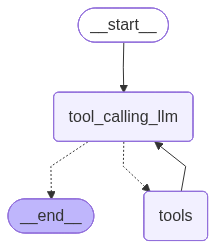

In [17]:
### Entire Chatbot With LangGraph
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news for MArch 3rd 2025,add 5 plus 5 and then multiply by 10")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news for MArch 3rd 2025,add 5 plus 5 and then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fka86pd3t)
 Call ID: fka86pd3t
  Args:
    query: top 10 recent AI news for March 3rd 2025
  add (gadjzvkzv)
 Call ID: gadjzvkzv
  Args:
    a: 5
    b: 5
  multiply (9e5szav76)
 Call ID: 9e5szav76
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Top 5 AI trends in March 2025: AI agents, smarter supply chains ...", "url": "https://www.neudesic.com/blog/top-5-ai-trends-march-2025/", "content": "March 2025 has brought a fresh wave of AI innovations that go beyond theoretical breakthroughs and translate directly into real-world impact. From OpenAI’s newly released tools for building AI agents